In [8]:
!pip install ucimlrepo pandas numpy matplotlib seaborn scikit-learn statsmodels mlxtend
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn
import random
from ucimlrepo import fetch_ucirepo
from itertools import combinations
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV, Ridge, Lasso, ElasticNet, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from itertools import product, combinations
from collections import Counter

{'uci_id': 183, 'name': 'Communities and Crime', 'repository_url': 'https://archive.ics.uci.edu/dataset/183/communities+and+crime', 'data_url': 'https://archive.ics.uci.edu/static/public/183/data.csv', 'abstract': 'Communities within the United States. The data combines socio-economic data from the 1990 US Census, law enforcement data from the 1990 US LEMAS survey, and crime data from the 1995 FBI UCR.', 'area': 'Social Science', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 1994, 'num_features': 127, 'feature_types': ['Real'], 'demographics': ['Race', 'Age', 'Income', 'Occupation'], 'target_col': ['ViolentCrimesPerPop'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2002, 'last_updated': 'Mon Mar 04 2024', 'dataset_doi': '10.24432/C53W3X', 'creators': ['Michael Redmond'], 'intro_paper': {'ID': 405, 'type': 'NATIVE', 'title': 'A data-driven software tool for enabling cooperative information s

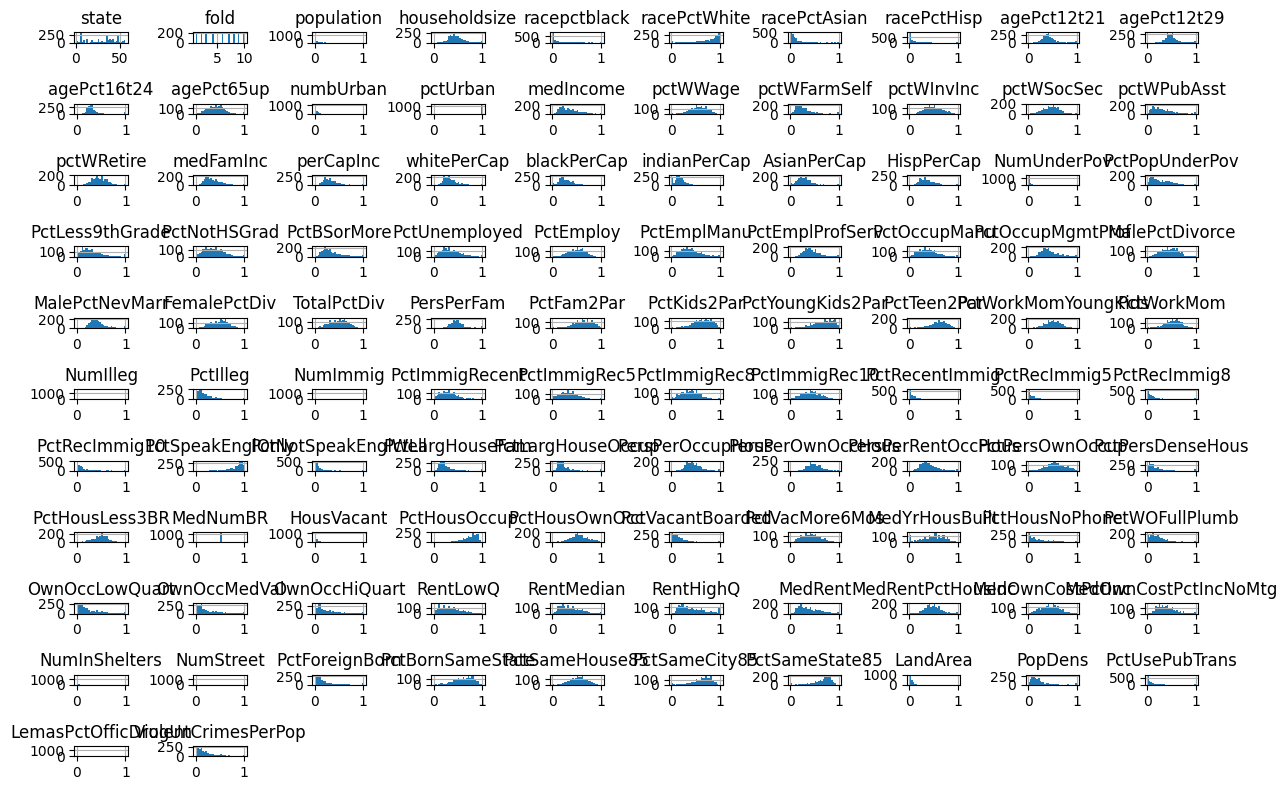

Columns with >40% missing values: ['PolicBudgPerPop', 'LemasGangUnitDeploy', 'LemasPctPolicOnPatr', 'PolicCars', 'PolicOperBudg', 'PolicAveOTWorked', 'LemasTotalReq', 'LemasSwFTFieldPerPop', 'PctPolicWhite', 'RacialMatchCommPol', 'LemasSwFTPerPop', 'LemasSwFTFieldOps', 'PolicReqPerOffic', 'LemasTotReqPerPop', 'LemasSwornFT', 'PolicPerPop', 'OfficAssgnDrugUnits', 'PctPolicMinor', 'PctPolicBlack', 'NumKindsDrugsSeiz', 'PctPolicAsian', 'PctPolicHisp', 'community', 'county']
['OtherPerCap']


In [2]:
# fetch the dataset from UCI server
com_and_crime = fetch_ucirepo(id=183)

# Extract features and targets
X = com_and_crime.data.features
y = com_and_crime.data.targets

# Create combined dataframe
df = pd.concat([X, y], axis=1)

# ~Part 0: Data Preprocessing~
# Replace '?' with NaN
df.replace('?', np.nan, inplace=True)

# Show Metadata and see distribution of the data
print(com_and_crime.metadata)
print("Initial shape:", df.shape)
print(df.describe())
df.hist(bins=30, figsize=(12, 8))
plt.tight_layout()
plt.show()

# Identify columns with high missing values
missing = df.isna().mean().sort_values(ascending=False)
high_missing = missing[missing > 0.4].index
print("Columns with >40% missing values:", high_missing.tolist())

# Remove columns with >40% missing values
df.drop(columns=high_missing, inplace=True)
# Remove non-predictive columns
df.drop(columns=['communityname', 'state', 'county', 'community', 'fold'],inplace=True, errors='ignore')

# Check which column is still non-numerical after removal of columns
object_cols = [col for col in df.columns if df[col].dtype == 'object']
print(object_cols)

# Convert the column into floating and check if conversion is successful
df['OtherPerCap'] = pd.to_numeric(df['OtherPerCap'], errors='coerce')
print(df.OtherPerCap)

# Impute a value for the only missing value in OtherPerCap
imputer = SimpleImputer(strategy='median')
df['OtherPerCap'] = imputer.fit_transform(df[['OtherPerCap']])

# Ensure there is no more missing value
print("Remaining missing values:", df.isna().sum().sum())

# Compute the correlation matrix and plot the heatmap to get a sense of what is happening in dataset
corr_matrix = df.corr()
print(corr_matrix)
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# ~Part 1: Data Analysis~
# (a) (i) Compare and contrast
# Split dataset into features and target
X = df.drop(columns=['ViolentCrimesPerPop'])
y = df['ViolentCrimesPerPop']
print(X)
print(y)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1 Least Square method
num_features = 10
X_const = sm.add_constant(X)
ols_model = sm.OLS(y, X_const).fit()

# Get p-values and sort features by significance
ols_pvalues = ols_model.pvalues.sort_values()
print("Top features based on Least Squares p-values:")
print(ols_pvalues.head(num_features))

# 2 Best Subset: use smaller set of␣pre-selected features as determined by significance
significant_features = ols_pvalues[ols_pvalues < 0.01].index.drop("const", errors="ignore") # Remove intercept
X_significant = X[significant_features]

def best_subset(X, y):
    best_score = float("inf")
    best_features = None

    for subset in combinations(X.columns, num_features):
        X_sub = X[list(subset)]
        X_sub_const = sm.add_constant(X_sub)
        model = sm.OLS(y, X_sub_const).fit()
        score = model.aic # Use AIC to evaluate model

        if score < best_score:
            best_score = score
            best_features = subset

    return best_features

best_features = best_subset(X_significant, y)
print("Best subset features:")
print("\n".join(best_features))

# 3 Best feature from RFE
rfe = RFE(LinearRegression(), n_features_to_select=num_features)
rfe.fit(X_scaled, y)
selected_features = X.columns[rfe.support_]
print("Top features from RFE:")
print("\n".join(selected_features))

# 4 Lasso Selection
lasso = LassoCV(cv=5).fit(X_scaled, y)
lasso_coefs = pd.Series(lasso.coef_, index=X.columns)

# Interpret most important features as those with largest absolute weight
top_lasso_features = np.abs(lasso_coefs).sort_values(ascending=False)
print("Top Lasso Features:")
print(top_lasso_features[:num_features])

# 5 Elastic Net Selection
elastic_net = ElasticNetCV(cv=5).fit(X_scaled, y)
enet_coefs = pd.Series(elastic_net.coef_, index=X.columns)

# Interpret most important features as those with largest absolute weight
top_enet_features = np.abs(enet_coefs).sort_values(ascending=False)
print("Top Elastic Net Features:")
print(top_enet_features[:num_features])

# Compile result
results = {
    "OLS Significance": ols_pvalues,
    "Best Subsets": best_features,
    "RFE": selected_features,
    "Lasso": top_lasso_features,
    "Elastic Net": top_enet_features
}


# Aggregate feature votes from respective methods to see which features get picked the most or the least
all_features = [f for sublist in results.values() for f in sublist]
feature_counts = Counter(all_features)

# Plot feature importance consensus
plt.figure(figsize=(20, 20))
pd.Series(feature_counts).sort_values().plot(kind='barh')
plt.title('Feature Selection Consensus Across Methods')
plt.xlabel('Number of Methods Selecting Feature')
plt.ylabel('Features')
plt.show()

# Plot heatmap for showing the features picked by each method
comparison_df = pd.DataFrame(index=X_scaled.columns)
for results, features in results.items():
    comparison_df[results] = comparison_df.index.isin(features).astype(int)

plt.figure(figsize=(30, 30))
sns.heatmap(comparison_df.T, cmap='Blues')
plt.title("Feature Presence Across Methods")
plt.xlabel("Features")
plt.ylabel("Selection Methods")
plt.show()

In [ ]:
# Fit and visualize regularization path

# Lasso and Ridge
alphas = np.logspace(-4, 1, 50)

lasso_coefs = []
ridge_coefs = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=5000)
    lasso.fit(X_scaled, y)
    lasso_coefs.append(lasso.coef_)
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_scaled, y)
    ridge_coefs.append(ridge.coef_)

lasso_coefs = np.array(lasso_coefs)
ridge_coefs = np.array(ridge_coefs)

# Elastic Net with two different alphas

alpha_1 = 0.3
alpha_2 = 0.7

l1_ratios = np.linspace(0.1, 0.9, 50) # From mostly Ridge to mostly Lasso

elastic_net_coefs_1 = []
elastic_net_coefs_2 = []

for l1_ratio in l1_ratios:
    # Elastic Net with first alpha
    elastic_net_1 = ElasticNet(alpha=alpha_1, l1_ratio=l1_ratio, max_iter=5000)
    elastic_net_1.fit(X_scaled, y)
    elastic_net_coefs_1.append(elastic_net_1.coef_)

    # Elastic Net with second alpha
    elastic_net_2 = ElasticNet(alpha=alpha_2, l1_ratio=l1_ratio, max_iter=5000)
    elastic_net_2.fit(X_scaled, y)
    elastic_net_coefs_2.append(elastic_net_2.coef_)

elastic_net_coefs_1 = np.array(elastic_net_coefs_1)
elastic_net_coefs_2 = np.array(elastic_net_coefs_2)

plt.figure(figsize=(10, 7))

# Lasso
plt.subplot(2, 2, 1)
plt.plot(alphas, lasso_coefs)
plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("Coefficients")
plt.title("Lasso Path")

# Ridge
plt.subplot(2, 2, 2)
plt.plot(alphas, ridge_coefs)
plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("Coefficients")
plt.title("Ridge Path")
plt.tight_layout()
plt.show()

# Plot Elastic Net regularization paths
plt.figure(figsize=(10, 7))

# Elastic Net (Alpha 1)
plt.subplot(2, 2, 1)
plt.plot(l1_ratios, elastic_net_coefs_1)
plt.xlabel("L1 Ratio")
plt.ylabel("Coefficients")
plt.title(f"Elastic Net Path (Alpha = {alpha_1})")

# Elastic Net (Alpha 2)
plt.subplot(2, 2, 2)
plt.plot(l1_ratios, elastic_net_coefs_2)
plt.xlabel("L1 Ratio")
plt.ylabel("Coefficients")
plt.title(f"Elastic Net Path (Alpha = {alpha_2})")
plt.tight_layout()
plt.show()

In [ ]:
# We create the results dictionary to keep track of the mean squared error (MSE) for each method.
# Notably, for each iteration, we split the data as instructed and scale X_train. We use the same scaling for X_train on X_val and X_test.
# For any method that has tunable hyperparameters, on each iteration we use grid search to find a value of the hyperparameter that minimizes the MSE on the validation set, and then we use this value to fit the model and evaluate it on the test set. For RFE, the hyperparameter is the proportion of features we use.

num_iterations = 10
results = {
    "Least Squares": [],
    "Ridge": [],
    "Best Subsets": [],
    "RFE": [],
    "Lasso": [],
    "Elastic Net": []
}

for _ in range(num_iterations):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4)
    scaler_X_train = StandardScaler()
    X_train = pd.DataFrame(scaler_X_train.fit_transform(X_train), columns=X.columns)

    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)
    X_val = pd.DataFrame(scaler_X_train.transform(X_val), columns=X_val.columns)
    X_test = pd.DataFrame(scaler_X_train.transform(X_test), columns=X_test.columns)

    # Least Squares
    model_ls = LinearRegression().fit(X_train, y_train)
    y_pred_ls = model_ls.predict(X_test)
    results["Least Squares"].append(mean_squared_error(y_test, y_pred_ls))

    # Ridge Regression
    best_alpha = min(
        np.arange(0.1, 1.1, 0.1),
        key=lambda a: mean_squared_error(y_val, Ridge(alpha=a).fit(X_train, y_train).predict(X_val))
    )
    model_ridge = Ridge(alpha=best_alpha).fit(X_train, y_train)
    y_pred_ridge = model_ridge.predict(X_test)
    results["Ridge"].append(mean_squared_error(y_test, y_pred_ridge))

    # Best Subsets
    best_features = best_subset(X_significant, y)
    model_best_subset = LinearRegression().fit(X_train[list(best_features)], y_train)
    y_pred_best_subset = model_best_subset.predict(X_test[list(best_features)])
    results["Best Subsets"].append(mean_squared_error(y_test, y_pred_best_subset))

    # Recursive Feature Elimination
    def evaluate_prop(prop):
        selector = RFE(LinearRegression(), n_features_to_select=prop)
        selector.fit(X_val, y_val)
        selected_features = X_val.columns[selector.support_]
        model_val = LinearRegression().fit(X_val[selected_features], y_val)
        y_pred_val = model_val.predict(X_val[selected_features])

        return mean_squared_error(y_val, y_pred_val)

    best_prop = min(np.arange(0.1, 1, 0.1), key=evaluate_prop)
    rfe = RFE(LinearRegression(), n_features_to_select=best_prop)
    selector = rfe.fit(X_train, y_train)
    selected_features = X_train.columns[selector.support_]
    model_rfe = LinearRegression().fit(X_train[selected_features], y_train)
    y_pred_rfe = model_rfe.predict(X_test[selected_features])
    results["RFE"].append(mean_squared_error(y_test, y_pred_rfe))

    # Lasso
    best_alpha = min(
    np.logspace(-4, 1, 10),
    key=lambda a: mean_squared_error(y_val, Lasso(alpha=a,max_iter=10000).fit(X_train, y_train).predict(X_val)))

    model_lasso = Lasso(alpha=best_alpha, max_iter=10000).fit(X_train, y_train)
    y_pred_lasso = model_lasso.predict(X_test)
    results["Lasso"].append(mean_squared_error(y_test, y_pred_lasso))

    # Elastic Net
    alpha_values = np.logspace(-4, 1, 10)
    l1_ratio_values = np.arange(0.1, 1.1, 0.1)
    best_alpha, best_l1_ratio = min(
        [(a, l1) for a in alpha_values for l1 in l1_ratio_values],
        key=lambda params: mean_squared_error(
            y_val, ElasticNet(alpha=params[0], l1_ratio=params[1], max_iter=10000).fit(X_train, y_train).predict(X_val)
        )
    )
    model_elastic = ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, max_iter=10000).fit(X_train, y_train)
    y_pred_elastic = model_elastic.predict(X_test)
    results["Elastic Net"].append(mean_squared_error(y_test, y_pred_elastic))

In [ ]:
# Visualize the results

import seaborn as sns
mse_data = []

for method, mse_values in results.items():
    for mse in mse_values:
        mse_data.append({"Method": method, "MSE": mse})

df_mse = pd.DataFrame(mse_data)

plt.figure(figsize=(10, 6))
sns.boxplot(x="Method", y="MSE", data=df_mse)
plt.xticks(rotation=45)
plt.title("Comparison of Prediction MSE Across Methods")
plt.ylabel("Mean Squared Error (MSE)")
plt.xlabel("Method")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [ ]:
# code up K-fold cross-validation from scratch

def get_folds(X, num_folds):
    folds = []
    fold_size = len(X) // num_folds
    indices = list(range(len(X)))
    random.shuffle(indices)

    for fold in range(num_folds):
        left_index = fold * fold_size
        right_index = min((fold + 1) * fold_size, len(X) - 1)
        test_indices = indices[left_index:right_index]
        train_indices = [i for i in indices if i not in test_indices]

        folds.append((train_indices, test_indices))

    return folds

def cross_validation(X, y, params, model_fn, score_fn, fit_fn = None, num_folds=5):
    # Create a dictionary where each element has the form
    # (('alpha', 1), ('gamma', 4), ('kernel', 'poly')): []
    # and so on, for each combination of parameter values

    scores = {
        tuple(dict(zip(params.keys(), values)).items()): []
        for values in product(*params.values())
    }

    for fold in get_folds(X, num_folds):
        train_indices, test_indices = fold
        X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
        y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

        for param in scores:
            param_dict = dict(param)
            model = model_fn(**param_dict)
            if not fit_fn:
                model = model.fit(X_train, y_train)

            else:
                model = fit_fn(model, X_train, y_train)

            y_pred = model.predict(X_test)
            scores[param].append(score_fn(y_test, y_pred))

    # Return the params with the smallest average score among the folds
    best_param = min(scores, key=lambda param : sum(scores[param]) / len(scores[param]))
    best_score = sum(scores[best_param]) / len(scores[best_param])

    best_param_dict = dict(best_param)
    best_param_dict['score'] = best_score
    return best_param_dict

In [ ]:
# use the function above to tune the alpha and gamma hyperparameters for the polynomial and RBF kernels. We use the default set above at 5 folds to keep the runtime reasonable, but 10 is also a common choice

# Define search space for hyperparameters
alpha_values = np.logspace(-3, 2, 10)
gamma_values = np.logspace(-3, 2, 10)

# Finding the best hyperparameters for Polynomial kernel
poly_results = cross_validation(
    X_train,
    y_train,
    params = {
        'alpha': alpha_values,
        'gamma': gamma_values,
        'kernel': ['poly'],
    },
    model_fn = lambda param: KernelRidge(**param),
    score_fn = mean_squared_error,
    num_folds = 5,
)

print(f"For the polynomial kernel:")
print(f"Best alpha: {poly_results['alpha']}")
print(f"Best gamma: {poly_results['gamma']}")
print(f"MSE: {poly_results['score']}")

In [ ]:
# Find the best hyperparameters for RBF kernel

rbf_results = cross_validation(
    X_train,
    y_train,
    params = {
        'alpha': alpha_values,
        'gamma': gamma_values,
        'kernel': ['rbf'],
    },
    model_fn = lambda param: KernelRidge(**param),
    score_fn = mean_squared_error,
    num_folds = 5,
)

print(f"For the rbf kernel:")
print(f"Best alpha: {rbf_results['alpha']}")
print(f"Best gamma: {rbf_results['gamma']}")
print(f"MSE: {rbf_results['score']}")

In [ ]:
# Compare with the built-in cross-validation function in sklearn

param_grid_poly = {'alpha': alpha_values, 'gamma': gamma_values, 'kernel': ['poly']}
param_grid_rbf = {'alpha': alpha_values, 'gamma': gamma_values, 'kernel': ['rbf']}
poly_model = GridSearchCV(KernelRidge(), param_grid_poly, cv=5, scoring='neg_mean_squared_error')
rbf_model = GridSearchCV(KernelRidge(), param_grid_rbf, cv=5, scoring='neg_mean_squared_error')

poly_model.fit(X_train, y_train)
rbf_model.fit(X_train, y_train)

print("Sklearn CV - Polynomial")
print(f"Alpha = {poly_model.best_params_['alpha']}")
print(f"Gamma = {poly_model.best_params_['gamma']}")
print(f"MSE = {-poly_model.best_score_}")

print("\nSklearn CV - RBF")
print(f"Alpha = {rbf_model.best_params_['alpha']}")
print(f"Gamma = {rbf_model.best_params_['gamma']}")
print(f"MSE = {-rbf_model.best_score_}")

In [ ]:
# compare the RBF and polynomial kernel ridge models with self-defined CV function to the linear regression models from previous sections

num_features = 10

# Least Squares
X_train_const = sm.add_constant(X_train).reset.index(drop=True)
y_train_ols = y_train.copy().reset_index(drop=True)
model_ols = sm.OLS(y_train, X_train_const).fit()

# Best subset
best_features = best_subset(X_significant, y_train_ols)
model_best_subset = LinearRegression().fit(X_train_const[list(best_features)], y_train_ols)

# Fit RFE using CV on the proportion of features used
# To understand what this algorithm is doing, note that for a fixed proportion p, we frst use RFE to select the most important p * 100% features and then ft OLS on those.
# Using the CV algorithm we built earlier isn’t straight forward due to the fact that we need to keep track of which features we are using as predictors, but the algorithm is mostly the same.

proportions = np.linspace(0.1, 0.9, 9)
model_rfe = None
model_rfe_features = None

for fold in get_folds(X_train, num_folds=5):
    train_indices, test_indices = fold
    X_train_cv, y_train_cv = X_train[train_indices], y_train[train_indices]
    X_val_cv, y_val_cv = X_train[test_indices], y_train[test_indices]

    best_MSE = float("inf")

    for prop in proportions:
        rfe = RFE(LinearRegression(), n_features_to_select=prop)
        rfe.fit(X_train_cv, y_train_cv)
        selected_features = X_train_cv.columns[rfe.support_]

        curr_model = LinearRegression().fit(X_train_cv[selected_features], y_train_cv)
        curr_MSE = mean_squared_error(y_val_cv, curr_model.predict(X_val_cv[selected_features]))

        if curr_MSE < best_MSE:
            best_MSE = curr_MSE
            model_rfe = curr_model
            model_rfe_features = selected_features

# Fit LASSO using built-in CV
model_lasso = LassoCV(cv=5).fit(X_train, y_train)

# Fit Elastic Net using built-in CV
model_elastic_net = ElasticNetCV(cv=5).fit(X_train, y_train)

# Fit Ridge using built-in CV
model_ridge = RidgeCV(cv=5).fit(X_train, y_train)

In [ ]:
# Compare models on test set

# Polynomial kernel
y_pred_poly = poly_model.predict(X_test)
mse_poly = mean_squared_error(y_test, y_pred_poly)

# RBF kernel
y_pred_rbf = rbf_model.predict(X_test)
mse_rbf = mean_squared_error(y_test, y_pred_rbf)

# OLS
X_test_const = sm.add_constant(X_test)
y_pred_ols = model_ols.predict(X_test_const)
mse_ols = mean_squared_error(y_test, y_pred_ols)

# Best Subsets
y_pred_best_subset = model_best_subset.predict(X_test_const[list(best_features)])
mse_best_subset = mean_squared_error(y_test, y_pred_best_subset)

# RFE
y_pred_rfe = model_rfe.predict(X_test[model_rfe_features])
mse_rfe = mean_squared_error(y_test, y_pred_rfe)

# LASSO
y_pred_lasso = model_lasso.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

# Elastic Net
y_pred_elastic_net = model_elastic_net.predict(X_test)
mse_elastic_net = mean_squared_error(y_test, y_pred_elastic_net)

# Ridge
y_pred_ridge = model_ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

print(f"MSE for the polynomial kernel: {mse_poly}")
print(f"MSE for the RBF kernel: {mse_rbf}")
print(f"MSE for OLS: {mse_ols}")
print(f"MSE for Best Subsets: {mse_best_subset}")
print(f"MSE for RFE: {mse_rfe}")
print(f"MSE for LASSO: {mse_lasso}")
print(f"MSE for Elastic Net: {mse_elastic_net}")
print(f"MSE for Ridge: {mse_ridge}")